## Introduction

We attempted to replicate the processing pipeline of the paper - Task-level Value Affects Trial-level Reward Processing (Hassall, Hunt, and Holroyd 2021). The researchers carried out their analysis in MATLAB 2022a using the EEGLab library, while we have used the python package ```mne-bids-pipeline``` that allows us to use py-mne functions in an easier way. The researchers provided a subset of their data, which we used in order to run our own pipeline. Since we did not have all the data from the original study, we predicted the results that we got would probably not be exactly like those in the paper, but we concentrated on doing the same processing steps as described in the paper.

### The original paper explained in brief

#### Experiment: 
- Participants were presented with **slot machines** ("trials") where they had to select one of two arms to pull. If the participant selected the correct arm on the slot machine, they would **"win"** at the machine and gain \\$0.03, while if they selected the wrong arm, they would **"lose"** the trial i.e. gain \\$0.00.
- The **win/loss feedback** for each slot machine was shown to them after they selected an arm. Their goal was to **win as much money as possible**.
- Each slot machine was preceded by a **cue** (coloured shape) shown to the participant. The slot machines were divided into three sets or **casinos** ("tasks").
- The different cues corresponded to **different types of slot machines**. Some machines, called **"low-value" machines**, had a 50% win probablility on both arms, while others called **"high-value machines"** had an 80% win probability on one arm and 20% on the other.
- For high-value machines, if the participant selected the 80%-arm it was considered a **"correct"** response. There was no "correct" response for a low-value machine.
- The **participants were not informed** of these differences. The **win amount was kept constant** across all slot machines.
- The **three casinos had a mix of high- and low- value machines** - one each of "high-value" and "low-value" task/casino containing only high-/low- value slot machines respectively, and a "mid-value" task containing equal numbers of both.
- Each of the 6 machine types was presented 24 times in random order (144 trials per task).

#### Research question: 
How does task-level reward processing affect trial-level value processing in ACC?

#### Data Preprocessing:
- Excluding participants who did not learn the cues - in order to be included, a participant should have **correct** responses for **at least 60% of the trials** in the mid and high value tasks.
- For each task, the first ten trials for each cue type were excluded, since it was assumed that the participants would still be learning the cues.

#### Analysis:
- The researchers looked into "Reward Positivity" (RewP), which corresponds to how much outcomes differ from learned action values \[1].
- They created the feedback-locked ERP (mean across epochs) for different task-cue-participant combinations. Then, they constructed difference waves between the mean win ERP and mean loss ERP across all participants for the task-cue combination.
- They examined the data from the FCz electrode between 240–340 ms post feedback, based on the recommendations from previous research on reward prediction. The RewP was defined as the maximum voltage within this window for each task-cue-participant.


### Some notes on using the dataset
- Although the paper says the data was sampled at 250 Hz, according to the dataset the sampling rate is 1000 Hz and we have proceeded assuming this 1kHz value.
- The paper states that the 10-20 electrode montage was used.
- Due to participants' wishes, only part of the data was shared by the researchers - that collected at the Oxford testing site. This means that we have fewer subjects to analyse, and also that the notch filtering required will be only at one frequency (50 Hz at Oxford).
- Each subject's 'eeg' subfolder contains a 'sub-XX_task-casinos_events.json' containing names and descriptions of the events like onset of fixation cross, cue onset, response, and feedback. This list is not complete, namely some events like S12, S22, S32 for the cue onsets are missing. However, the events are present in the data and can be used directly for data processing. We have also filled in these missing events and added them to this project folder as the file 'sub-XX_task-casinos_events_Restored.json'. 
- Event name format: Each event name consists of four characters, with spaces used for padding (e.g. ```S  6, S 16```). However in some forms of output (e.g. in jupyter notebooks that we used while initially exploring the data) it can show up as three characters (```S 6, S 16```) and in the json file mentioned above the names are also slightly different (```S6, S16```). 

### Authors' Pipeline vs. Our Pipeline - Overview

Overall, we tried to replicate the pipeline of the authors as closely as possible. Some steps were performed differently, the notes on which are as below:

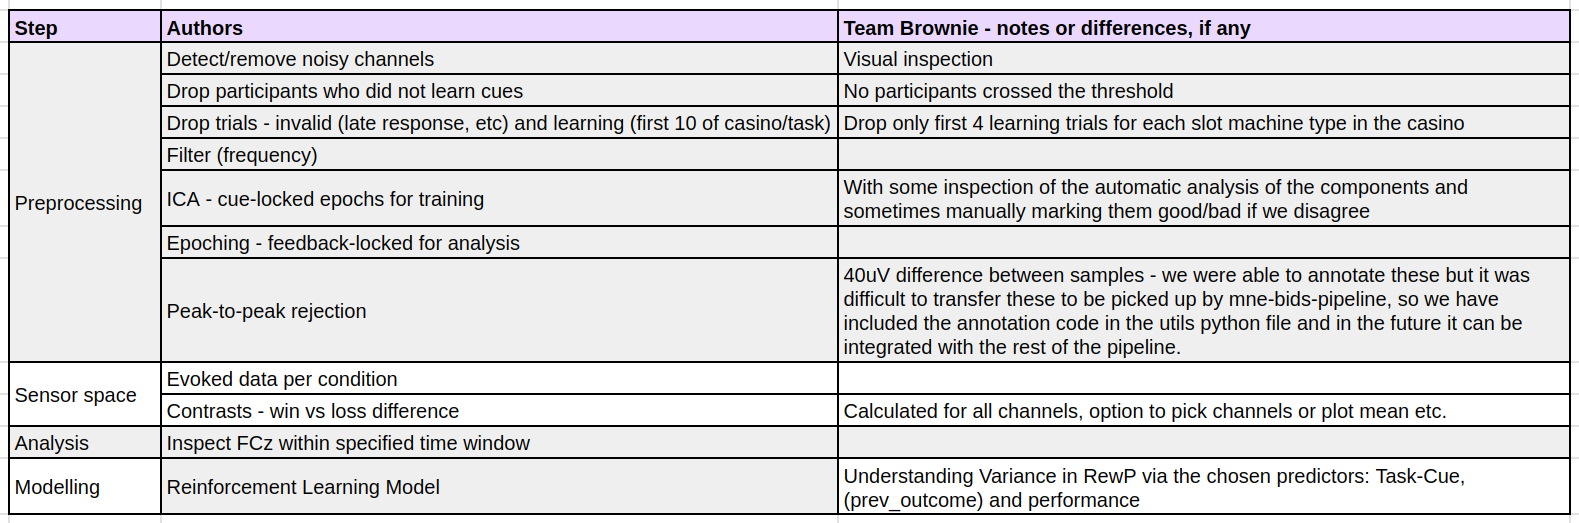



### Comparison our results - Paper results

Below you can see how our analysis results in slightly different graphs than the ones presented in the original paper.

On the top you can see the results for the win/loss waveforms of the original paper, on the bottom are our results.
The difference is not that much, however still present.

![](Report_Media/compared_3a_final.png "Result comparison win/loss waveforms")


Next, you can see the comparison of the difference waveforms, again with the original paper on the top and our results on the bottom.
In this case we can se a little more differences in the graphs compared to the first one. Since we don't have all participant data, since about half of them are not openly accessible this might be an explanation for the differences.

![](Report_Media/compared_3b_final.png "Result comparison win/loss waveforms")

### Visual Inspection of raw data to find bad channels/subjects

As a first pass, we plotted the raw eeg and looked through the data visually. 
```
import mne
%matplotlib qt
import matplotlib
import matplotlib.pyplot as plt
bids_root = "../project/Dataset/ds004147/"
subject_id = '27'
bids_path = BIDSPath(subject=subject_id,task="casinos",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)
raw = read_raw_bids(bids_path)
raw.load_data()
mne.viz.plot_raw(raw, duration=150,highpass=1,lowpass=50, scalings={"eeg":100e-6},n_channels=len(raw.ch_names))
```
A few notes on what we found:
 
- Subjects 35 and 36 had regular-looking troughs/peaks throughout the recording, about 5-10 times every ten seconds. One possibility is that these are blinks, but that seemed to be almost too frequent for an eyeblink, and we were not very sure what else it might be.

  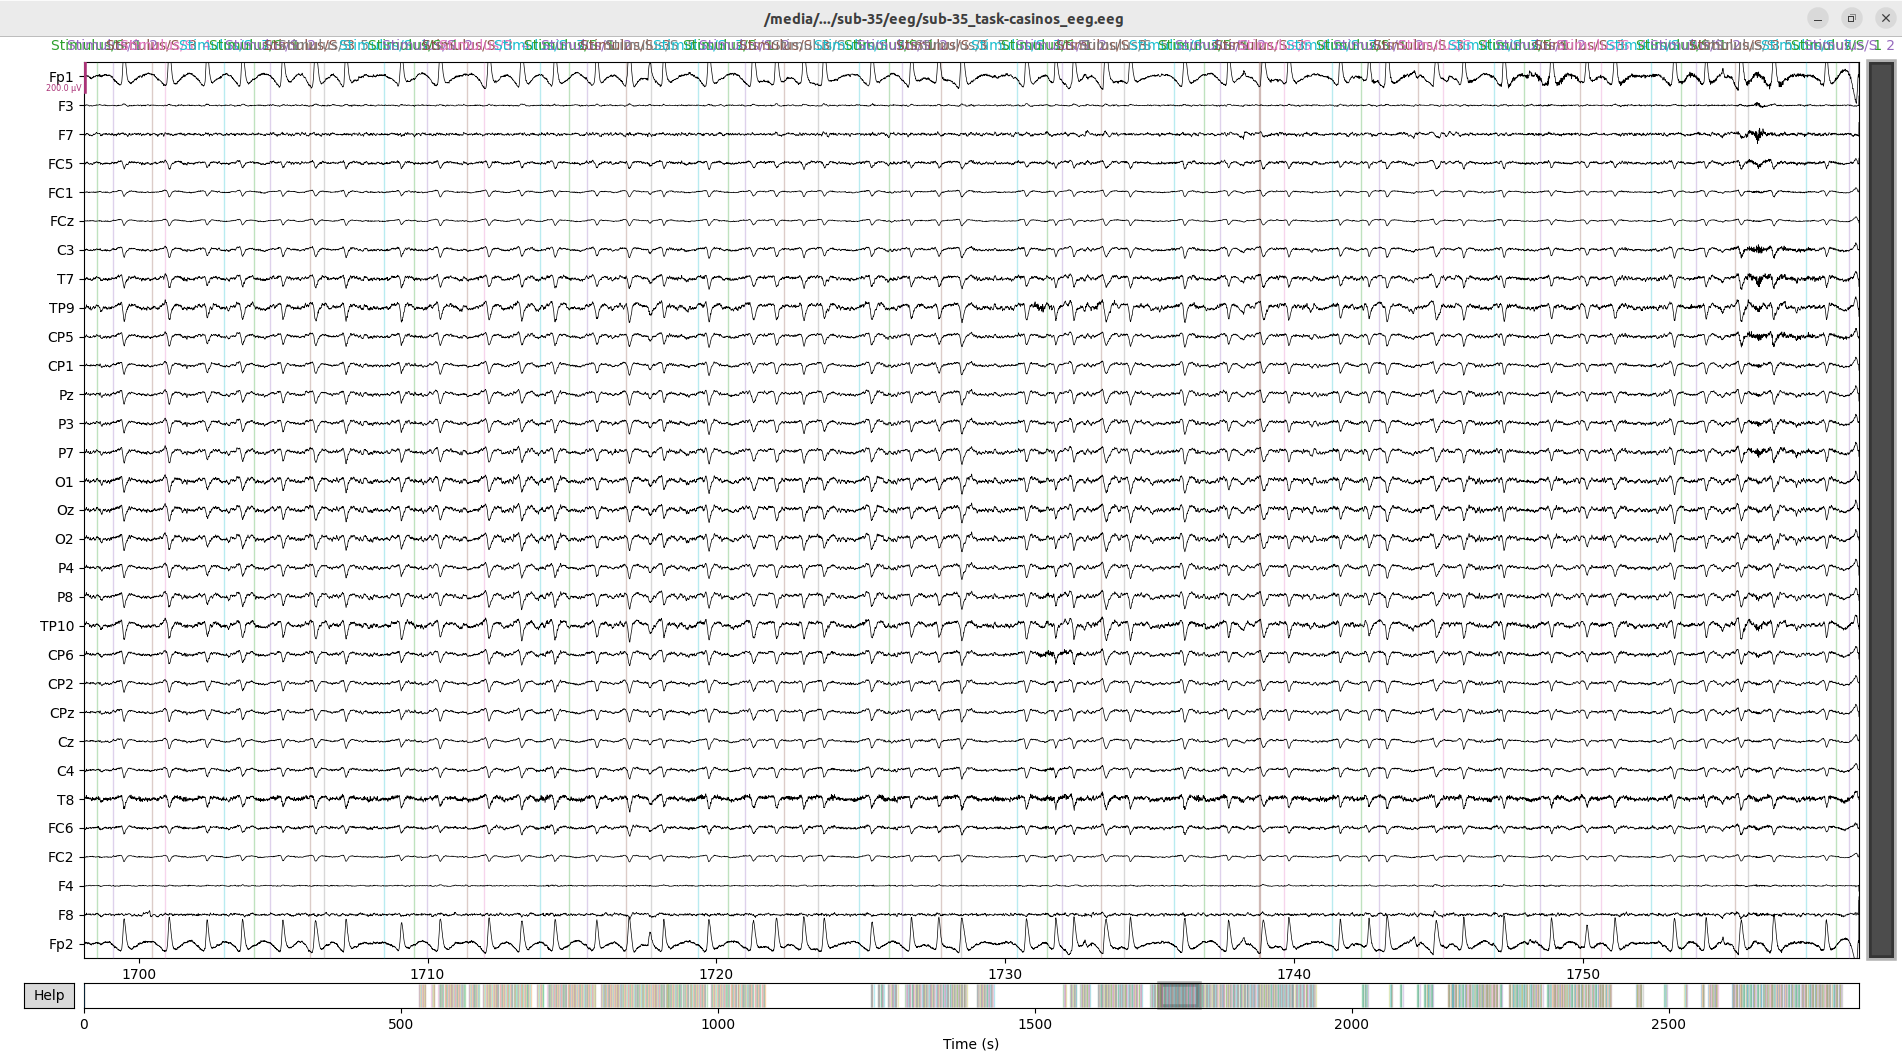

  However, after looking at the data post cleaning it did not seem very highly influenced by these artifacts - maybe after some deeper investigation it could be possible to remove them anyway, or if not then discard the subject. The paper states that only one participant had data with too many artifacts to be usable, so we believe they also used the data from these subjects after cleaning.
  
- The remaining subjects had no channels that we found to be obviously bad throughout. 
Across the board, all participants showed usable channel recordings, with none of them too noisy to be usable or too flat to be cautious about the recording quality. 
In general, Fp1 and Fp2 seemed to have the highest effects from eyeblinks, but since we set those as virtual EOG electrodes in the config file for the analysis, we believe those effects are also eliminated through the ICA training.

- Subjects 29 and 30 subjectively had the most noise in their channels overall, but we decided they are still within the acceptable range.

- For subject 38, channels FC1, FC2, F3, F4 and FCz were comparably flat, but they still looked usable and not like a failed recording of sensors or something like that, we found.

### Removing Participants and Trials from the Analysis.

Before passing the data to the automated pipeline, we exclude some trials and participants according to the rules below: 
1. We are removing the first **n**(=4) trials for every cue in every casino. This ensures that the participants are able to learn the pattern of every slot as we want to measure how the RewP changes in different average task values. For that the participants have to learn first how the cues of every slot machine correspond to the reward. Here, we decided to reduce the number of trials excluded per machine type (cue) to 4 trials, since we have less data to work with overall.
2. We are removing participants that do not manage to get **threshold** of the learnable trials correct, i.e. choosing the lever with the higher win probability. Thus, we assume that participants did not truly care about the reward or did not manage to learn the cues.

Hyperparameters: n=4, threshold=0.7, subjects_dir='Dataset/ds004147-filtered'

   ```removed_trial_dict=drop_learning_nonlearner_invalid_trials(n=n, threshold=threshold, subjects_dir=subjects_dir)```
   
After choosing n=4 and threshold=0.7, no participants went under the threshold. The authors noted that some were excluded, so we believe that these participants were from the other test site.

### Filter the first n=4 trials for every slot in every casino for every participant

During the removal of bad participants, we also returned a filtered beh.tsv without the first n=4 trials. We do this for the eeg.vmrk and events.tsv files, respectively. Moreover, invalid trials are also removed, as the data is unnecessary.

Hyperparameters: subjects_dir='Dataset/ds004147-filtered'
Parameters: removed_trial_dict retrieved from drop_learning_nonlearner_invalid_trials

```drop_trials_events(removed_trial_dict, subjects_dir)```


#### Invalid Trials over Time

The complete experiment run for each subject is really long (**amount of time and number of breaks**). So it might be interesting to see the number of invalid trials for each participant over time. 
```
import matplotlib.pyplot as plt
# unpickle the invalid_trials dict: [subject, list of 0 and 1 for invalid or not in order of trials done]
with open('invalid_trials.pkl', 'rb') as f:
    invalid_trials = pickle.load(f)
plot_invalid_trials_over_time_stacked(invalid_trials)
```

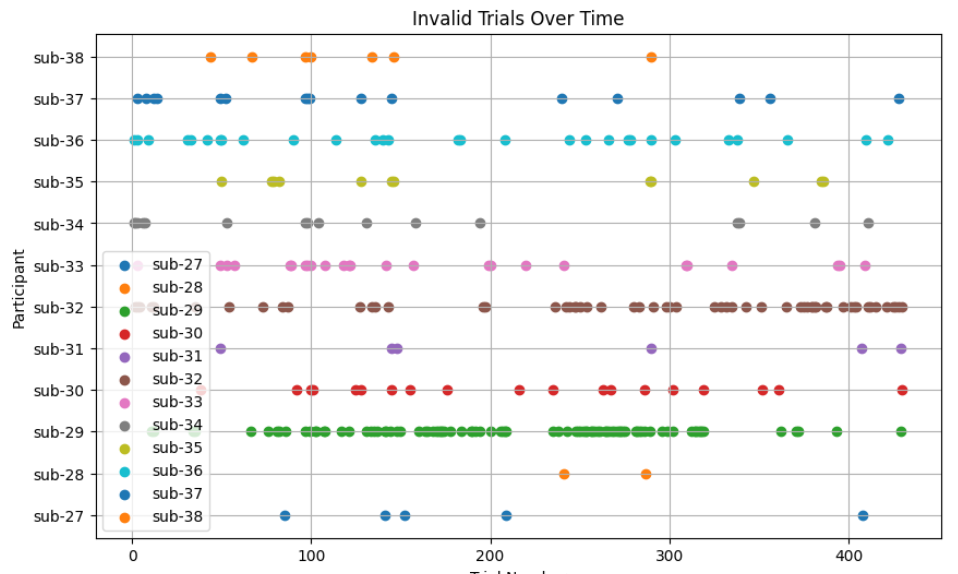

We noticed that subject 29 had nearly 25% of the trials incorrect and subject 32 nearly 15% incorrect, however we have included these subjects in the analysis since they still got the majority of trials right. The rest of the subjects all had more than 90% of the trials correctly answered.

### Pipeline Configuration - thought process

#### Downsampling:

To save on processing power required, we had initially downsampled the data from 1000 Hz to 150 Hz. ```mne-bids-pipeline``` constructs the PSD plot for frequencies up to 1.5 * lowpass_cutoff_frequency. Thus 150 Hz is sufficient to allow us to include all required frequencies in our analysis.
However, the performance after resampling is also not noticeably better than without resampling, so we opted not to resample to avoid losing out on raw data.

#### Filtering:

- We have used a band-pass filter (0.1 - 50Hz) since frequencies of interest for EEG analysis would lie within this band.
- A notch filter at 50Hz is applied (power line frequency at the Oxford site).
- If the data from the other site had also been available, we could have run the filtering step twice with the respective notch frequencies on the two groups of subjects by specifying the subject IDs in the configuration file. Then we could proceed with the next steps running on all subjects, since mne-bids-pipeline caches the intermediate results of processing steps.

#### Re-Referencing:

The authors re-referenced to the average of the mastoid signals, using the "TP9" and "TP10" channels. 
Since this is a common rereferencing scheme, we have used the same, by setting the relevant parameter in the config file as follows:
```eeg_reference = ['TP9', 'TP10']``` .

#### Epochs

Following the paper, we have selected epochs as follows:
- ICA training - cue-locked, 0 to 3 seconds 
- ERP analysis - feedback-locked, -200ms to +600ms

#### Events

For this analysis, we selected the events related to win/loss feedback, i.e. S6, S16, S26, S36, S7, S17, S27, S37. These can be specified in the 'conditions' parameter of the configuration file. We can also rename the events for human-readability, specifying the event type - cue, beep, ..., win (feedback), loss (feedback) along with the task-cue combination - Low-Low (LL), Mid-Low (ML) and so on. There is a custom parameter ```renaming_flag``` which if set as ```True```, will rename the events.

In future, the pipeline can also be run for a different set of events by changing the 'conditions' parameter, e.g. we can analyse cue-locked waveforms rather than feedback-locked as we have done here, by including cue events even during the post-ICA step.

#### ICA for artifact removal:

Since the original paper uses ICA for artifact removal, we decided to do the same. Not only because it would probably lead to higher comparability of results, but also because it seems to be kind of agreed on in the community (from what we could find in different online forums) that ICA works better for EEG data than SSP does, as the latter might remove too much of the original signal.

The authors of the paper used different epochs for ICA (0-3 seconds starting at cue event) and for ERP analysis (-0.2 to +0.6 second epochs locked to feedback events).  In a previous version of the pipeline we were using (1.5), epoching was done before ICA, whereas in the latest version v1.7, the epoching step can be explicitly run after the ICA steps. 

For our pipeline, we have a variable ```ica_train_step``` (default False) which should be set to True when performing the ICA and back to False after the ICA training is done. This will cause the relevant settings like event names ("conditions") and epoch length to be set accordingly.

#### Peak-to-Peak based rejection

In the paper, the authors rejected an epoch from analysis if it had more than 150 microvolts of overall change across the epoch. We have done the same via the ```reject``` parameter.

#### Evoked potentials

- After the data is cleaned, we can get evoked data from the pipeline by setting the 'contrasts' value to specify the pairs of conditions between which we want to calculate differences. Here, we contrast feedback-locked epochs for win vs loss results for each of the task-cue combinations. The pipeline generates the evoked potentials for each subject and for all the individual conditions and contrasts we specify, when we run the appropriate pipeline step 'sensor/_01_make_evoked'.
- mne-bids-pipeline does have a configuration parameter ('analyze_channels') to carry out this analysis only for a subset of channels; however, when we tried to restrict it to only FCz like the researchers did in the original paper, we ran into an error somewhere in the package internals.
- So, since the package is still in active development, we wrote some utility code to run the further averaging and plotting ourselves.
- We take the pipeline output of the 'evoked' step and run our utility function (TODO name the function) to average the conditions over all the subjects. If we want to analyse a certain set of subjects, we can update sub_list in the utility function to contain only the subjects that we want (in future we could also pass this as a parameter instead, to make it more flexible). Similarly, we can select specific (or all) channels as well.
- We can plot the condition waveforms ("win/loss waveforms") and contrast waveforms ("difference waves") by passing the corresponding condition/contrast names to the plotting function.
```
from utils import *
%matplotlib qt

fig_conditions = plot_avg_evokeds(
    sub_list=["27","28","29","30","31","32","33","34","35","36","37","38"],
    cond_list=[ 
        'Win LL',
        'Loss LL',
        'Win ML',
        'Loss ML',
        'Win MH',
        'Loss MH',
        'Win HH',
        'Loss HH'
    ],
    colors={'Win LL':'r',
         'Win ML':'r',
         'Win MH':'r',
         'Win HH':'r',
         'Loss LL':'b',
         'Loss ML':'b',
         'Loss MH':'b',
         'Loss HH':'b'},
    linestyles={'Win LL':'solid',
         'Win ML':'dashed',
         'Win MH':'dashdot',
         'Win HH':'dotted',
         'Loss LL':'solid',
         'Loss ML':'dashed',
         'Loss MH':'dashdot',
         'Loss HH':'dotted'}
    )

fig_contrasts = plot_avg_evokeds(
    sub_list=["27","28","29","30","31","32","33","34","35","36","37","38"],
    cond_list=[ 
        'Win LL',
        'Loss LL',
        'Win ML',
        'Loss ML',
        'Win MH',
        'Loss MH',
        'Win HH',
        'Loss HH'
    ],
    colors=['#EE82EE','#EE82EE','#a020f0','#a020f0'],
    linestyles=['solid','dashed','dotted','dashdot']
    )
``` 


### Selecting ICA components

To find out which independent components in our dataset are bad, we first let the MNE BIDS pipeline run and let it do the automatic detection of potential EOG artifacts. We then manually analyzed the generated reports for each subject to see whether or not we agree with the automatic detection and made corrections if we felt they were needed.
More often than not, we made some modifications to the selection, which was done by editing the ```./Dataset/ds004147-filtered/derivatives/sub-XX/sub-XX_task-casinos_proc-ica_components.tsv``` file and setting the status of each independent component to "good" or "bad".
    
To decide which components were bad, we found it helpful to practise with the interactive tutorial provided by [this website](https://labeling.ucsd.edu/tutorial/practice), where one can just try and see whether their suspicion is correct or not.
    
As an example, here is the automatic output of the pipeline for subject 27:
    
![](./Report_Media/27icabefore.PNG "ICA sub27")
    
The independent components which the pipeline wanted to mark as "bad" are marked with a grey title, while the "good" ones have a black title.
Additionally, the pipeline report shows a comparison of the signal before and after cleaning, so we could see how good it presumably was. This can be seen, again for subject 27, here:
    
![](./Report_Media/27icabeforeRB.PNG "ICA sub27")
    
Through our practise with the website mentioned above and our own suspicions, we then proceeded to check if we agree with the pipelines decision. 
In the case of subject 27, we for example thought that ICA001, ICA003 and ICA005 might contain some useful information and should be kept, while ICA004, ICA006, ICA007 and ICA008 are rather bad, so we updated the .tsv file, as mentioned above.
    
After we completed this process for all subjects, we ran the rest of the pipeline as explained below, which then generated a new report with the independent components we marked as "bad" and a new comparison between the uncleaned and cleaned signals, this time on a different epoch, as in our case the ICA is trained on other epochs than the ones it is applied to.
    
This new report then served as another way for us to check whether we might have chosen the wrong independent components or not, and in the case of our example with subject 27, it looks like this:
    
![](./Report_Media/27icaafterRB.PNG "ICA sub27")

### Try it Yourself!

These are the steps to run the analysis from start to end:

1. **Download the dataset and extract it** to a folder of your choice. For us, the main project folder was "EEG2324Brownie" and the dataset in the folder 'Dataset/ds004147' inside it.
2. **Removing participants, invalid trials, and learning trials** from the dataset - run the functions drop_learning_nonlearner_invalid_trials and drop_trials_events from ```utils.py``` as explained above. This creates a new folder 'Dataset/ds004147-filtered/', which is the folder to use for the actual analysis.  
3. **Initialisation**: In the config file ```brownie-config.py```, set the values of parameters like study_name (main project folder - for us, 'EEG2324Brownie'), bids_root (should point to the new 'ds004147-filtered' folder), subjects (if you want to analyse only a few subjects vs. all), etc. (TODO check full list after cleaning up config file)
4. **Filtering and ICA step**:
    - Set ```ica_train_step = True``` in the configuration file
    - Run the initial pipeline steps from the command line:
      ```mne_bids_pipeline --config=./brownie-config.py --steps=init,preprocessing/_01_data_quality,preprocessing/_04_frequency_filter,preprocessing/_06a1_fit_ica,preprocessing/_06a2_find_ica_artifacts ```
    - The pipeline will create a new folder 'derivatives/mne_bids_pipeline' within the 'ds004147-filtered' folder (if it doesn't exist already) and store its outputs there. 
5. **ICA component inspection**: For each subject analysed, open the corresponding folder in the derivatives section and inspect the report at sub-XX_task-casinos_proc-ica+components_report.html. In sub-XX_task-casinos_proc-ica_components.tsv you can mark individual ICA components as 'bad' or 'good' depending on what the pipeline has auto-classified as well as from personal judgement, and then save this file to be used for the next step.
6. **Continue with epoching and apply ICA**:
   - set ```ica_train_step = False``` to make sure analysis epochs are correctly created
   - Run ```mne_bids_pipeline --config=./brownie-config.py --steps=preprocessing/_07_make_epochs,preprocessing/_08a_apply_ica```
   - You can see the output of the ICA cleaning in sub-XX_task-casinos_report.html
8. **Peak-to-Peak rejection**: run ```mne_bids_pipeline --config=./brownie-config.py --steps=preprocessing/_09_ptp_reject```
9. **Evoked Potentials**:
   - run ```mne_bids_pipeline --config=./brownie-config.py --steps=sensor/_01_make_evoked```
   - run the utility function plot_avg_evokeds() as shown above, to load and plot the evoked data. If you want to view only a subset of channels (e.g. only FCz), change the list in 'picks' before plotting - by default if multiple channels are selected they will be averaged. You can also select which subjects to plot by changing the list passed to the function.

### Further Analysis

As a further analysis, we build a linear model to understand the relationship between selected predictors and the RewP. Specifically, we want to understand how predictors from the papers, such as task-cue pair and performance, contribute to RewP and confirm (or not!) the results from the paper, but also understand how new self-selected predictors, such as response time and previous trial outcome, might affect RewP. 

#### Setup

We used mne-bids-pipeline v1.7.0, running on Windows and on Ubuntu Linux. The environment can be replicated using the environment file available in the git of this project. 

#### References

Paper: https://doi.org/10.1016/j.neuroimage.2022.119456.

BIDS data format: doi:10.1038/sdata.2016.44

